In [5]:
%load_ext autoreload
%autoreload 2

# Загрузка кода при работе через Colab

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   ! git clone https://github.com/VasilievArtyom/PneumothoraxSegmentation.git
   ! cd PneumothoraxSegmentation

# Установка необходимых библиотек

In [2]:
# ! pip install -q -r requirements.txt

# Загрузка данных

In [4]:
! wget -nc https://fls.avasiliev.xyz/Lectures/PathologySegmentation/SIIM-ACR-Pneumothorax-Segmentation.zip 
! unzip -n -q SIIM-ACR-Pneumothorax-Segmentation.zip

File ‘SIIM-ACR-Pneumothorax-Segmentation.zip’ already there; not retrieving.



# Структура репозитория PneumothoraxSegmentation

## Конфигурационные файлы

Для удобства работы весь процесс обучения контролируется через конфигурационные файлы:

In [94]:
from train_wrapper import load_config

In [124]:
train_config = load_config('configs/train.yaml')

In [120]:
train_config

{'data_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'annotation_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'exp_path': 'Experiments',
 'annotations': 'train.csv',
 'images': 'dicom-images',
 'masks': 'masks',
 'val_annotations': 'val.csv',
 'val_images': 'dicom-images',
 'val_masks': 'masks',
 'exp_name': 'baseline',
 'project': 'SIIM-ACR-Pneumothorax-Segmentation',
 'trainer': {'precision': 32,
  'sync_batchnorm': True,
  'gradient_clip_val': 1.0,
  'max_epochs': 10,
  'accelerator': 'auto',
  'devices': 'auto'},
 'weights': None,
 'model': {'smp_model_name': 'Unet',
  'kwargs': {'encoder_name': 'tu-tf_efficientnet_b0',
   'encoder_weights': 'imagenet',
   'in_channels': 3,
   'classes': 1}},
 'dataloader': {'batch_size': 8, 'num_workers': 2},
 'preprocess': {'side_size': 512,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'transforms': [{'name': 'RandomBrightnessContrast',
   'kwargs': {'brightness_by_max': True, 'p': 0.5}},
  {'name': 'ImageCompression',
   '

То есть через конфигурационный файл можно задать путь до данных, какую именно модель учить и какие выбирать параметры оптимизации, относительно какой метрики нужно контролировать процесс переобучения.

## Класс датасета для работы с данными во время обучения

In [108]:
from datasets.train import TrainDataset
import matplotlib.pyplot as plt

In [109]:
train_ds = TrainDataset(config=train_config)

In [110]:
len(train_ds)

10165

In [111]:
train_ds[0].keys()

dict_keys(['image', 'mask', 'label', 'idx'])

In [112]:
train_ds[0]['image'].shape, train_ds[0]['mask'].shape

(torch.Size([3, 512, 512]), torch.Size([512, 512]))

In [113]:
train_ds[0]['label']

tensor([1])

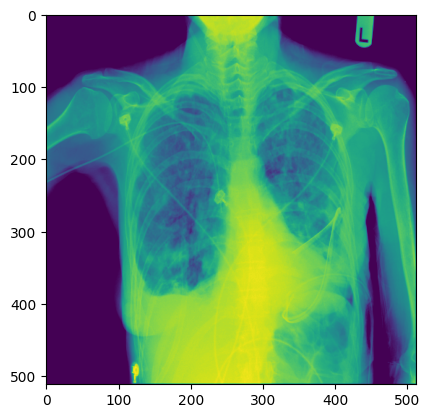

In [114]:
plt.imshow(train_ds[0]['image'][0, ...])

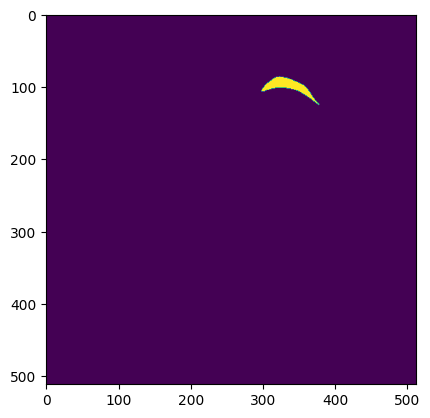

In [115]:
plt.imshow(train_ds[0]['mask'])

## Создание модели из конфигурационного файла

Мы будем использовать сегментационные модели из библиотеки segmentation_models_pytorch (smp):
- [github](https://github.com/qubvel-org/segmentation_models.pytorch)
- [Документация smp](https://smp.readthedocs.io/en/latest/)

In [175]:
train_config['model']

{'smp_model_name': 'Unet',
 'kwargs': {'encoder_name': 'tu-tf_efficientnet_b3',
  'encoder_weights': 'imagenet',
  'in_channels': 3,
  'classes': 1}}

В нашем коде уже реализован класс, который создаёт экземпляр модели на основе текстовой конфигурации:

In [176]:
from models.model import TorchModel

In [177]:
model = TorchModel(train_config['model'])

In [178]:
import torch

In [179]:
B, C, H, W = 4, 3, 512, 512 
dummy_input = torch.randn(B, C, H, W)
pred_mask, pred_label = model(dummy_input)

In [180]:
pred_mask.shape

torch.Size([4, 1, 512, 512])

In [181]:
pred_label.shape

torch.Size([4])

Модель возвращает предсказанную маску сегментации в сыром виде (логиты), а также выход классификатора (так же в виде логитов).

## Комбинированная функция потерь для сегментации и классификации

In [182]:
from losses.loss import TorchLoss

In [183]:
loss = TorchLoss()
loss_value = loss(
    preds_mask=pred_mask,
    preds_label=pred_label,
    target_mask=torch.randn(B, 1, H, W),
    target_label=torch.randn(B)
)

In [184]:
loss_value

tensor(1.1567, grad_fn=<AddBackward0>)

## Создание PyTorch Lightning пайплайна из конфигурационного файла

In [158]:
from pl_models import TrainPipeline

In [ ]:
from torchmetrics.segmen

# Обучение модели

Загружаем конфигурацию обучения:

In [ ]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
    %load_ext tensorboard
    %tensorboard --logdir {train_config['exp_path']} --port 6006